In [34]:
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[i:]) for i in range(sc_data.shape[0])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    matplotlib.pyplot.scatter(df.iloc[row_num,:], time)
    

    





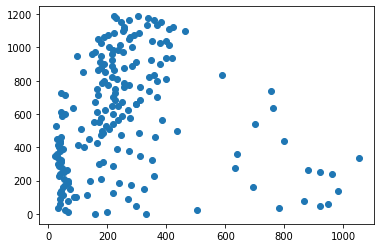

In [27]:
s745_df = get_normed_and_zero_filtered_data("data/sub_0745_miRNA.ec.tab")
s745_time = get_s745_time(s745_df.columns)
s814_df = get_normed_and_zero_filtered_data("data/sub_0814_miRNA.ec.tab")

plot_one_row_scatter(s745_df, 1,s745_time )


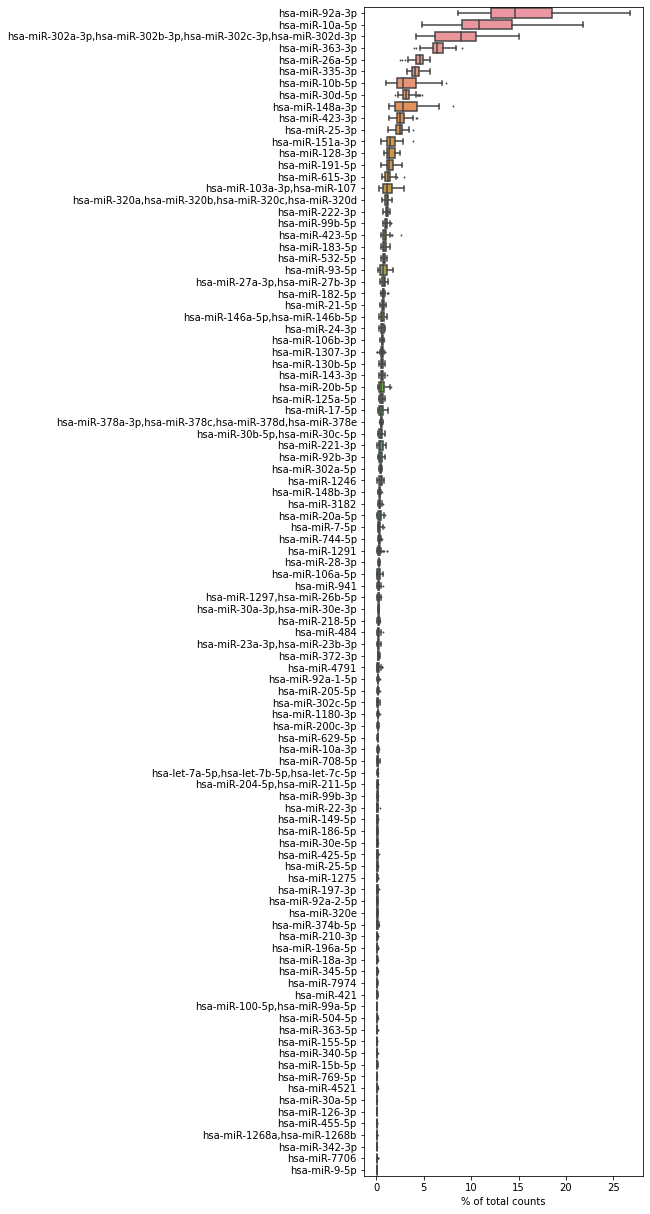

In [60]:
 
s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)

sc.pp.normalize_total(s814_adata)
sc.pp.filter_genes(s814_adata, min_counts=1)
sc.pl.highest_expr_genes(s814_adata, n_top=100, )
#s814_pd = get_periodgram(s814_adata)
#


In [13]:
obj.apply(mean)
mean(obj)

s814_pd = s814_df.apply(signal.periodogram, axis=1)

In [38]:
s814_pd.shape
np.log(s814_pd[1][1]+1)



array([ 0.        , 12.01343341, 11.38450693, 10.77910722,  9.4579665 ,
        8.73896987,  8.75961682,  8.59944222, 10.10584774,  8.91066591,
        9.96935723,  9.19331011, 11.59898035,  9.46578029,  6.69608845,
        7.87754352,  7.89914664,  9.50714677,  8.5491996 ,  8.41180671,
        7.62701821,  9.4535331 ,  8.81810054,  6.4860254 ,  9.38095257,
        8.85635717,  8.3971351 ,  8.85186594,  9.35518892,  7.89124325,
        7.4890114 ,  7.20386721,  6.79906888,  9.74412627,  7.41399943,
        9.17983261, 10.19044603,  7.73953827,  7.55891789,  8.19793317,
        7.38970494,  8.21306347,  8.7021317 ,  9.11430439,  9.18014594,
        5.53686622,  9.1599944 ,  7.61897029,  0.79202041])

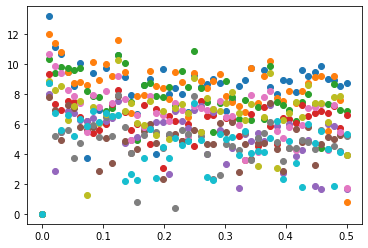

In [39]:
for i in range(10):
    matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

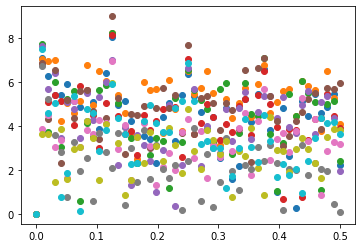

In [42]:
for i in range(10,20):
    matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

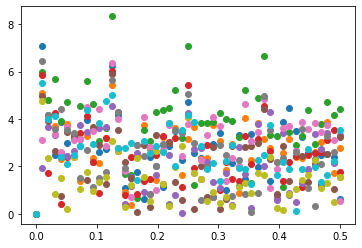

In [43]:
for i in range(20,30):
    matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))